In [1]:
import pandas as pd
from biodata.delimited import DelimitedWriter
import numpy as np
from collections import defaultdict
import pybedtools
from biodatatools.utils.common import json_load
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess
from Bio import SeqIO
import itertools
from statannotations.Annotator import Annotator
import logomaker
import pickle
from pathlib import Path
import sys

Matplotlib is building the font cache; this may take a moment.


In [40]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9
lw = 0.8

In [3]:
sys.path.append(str(Path.cwd().parent))
import utils

In [24]:
PROJECT_DIR_d = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_d2 = "/fs/cbsuhy02/storage/yc2553/yc2553/databases/"
PROJECT_DIR_s = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_o = "/home/yc2553/projects/HEA/output/"
PROJECT_DIR_o2 = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/"

# Browser shots

In [5]:
labels = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/classifications.json")

In [7]:
metafile = f"{PROJECT_DIR_o}tables/SuppTable1.xlsx"
df_metrics = pd.read_excel(metafile, sheet_name=2)
reads = {}
for _, row in df_metrics.iterrows():
	reads[row["PRO-cap sample ID"]] = row["Uniquely mapped, deduplicated read pairs"]

In [8]:
for s in labels:
	if reads[s] >= 10e6 and labels[s][1] in ["Esophagus", "Stomach", "Small intestine", "Large intestine"]:
		print(s, labels[s])

GT12 ['Esophagus muscularis mucosa', 'Esophagus']
GT19 ['Esophagus squamous epithelium', 'Esophagus']
GT7 ['Gastroesophageal sphincter', 'Esophagus']
EN14 ['Left colon', 'Large intestine']
EN24 ['Mucosa of descending colon', 'Large intestine']
EN5 ['Colonic mucosa', 'Large intestine']
GT25 ['Transverse colon', 'Large intestine']
HN10 ['Rectum', 'Large intestine']
CHTN12 ['Ileum', 'Small intestine']
CHTN2 ['Duodenum', 'Small intestine']
EN47 ['Jejunum', 'Small intestine']
GT24 ["Peyer's patch", 'Small intestine']
GT6 ['Stomach', 'Stomach']


In [9]:
# Focus on GI samples
# Display the samples in the anatomical order: 

samples = ["GT19", "GT12", "GT7", 
		   "GT6",
		   "CHTN2", "EN47", "CHTN12", "GT24", 
		   "GT25", "EN14", "EN24", "EN5", "HN10"
		   ]

In [10]:
rpm_bws = {}
for s in samples:
	rpm_bws[s] = [f"{PROJECT_DIR_o}rpm/{s}_{k}_rpm.bw" for k in ["pl", "mn"]]

In [11]:
# Get fine-mapped variants from https://www.nature.com/articles/nature22969
# rs6426833: a fine-mapped variant associated with UC

# 0-based
chrom, snp_pos, rsid, ref, alt = "chr1", 19845366, "rs6426833", "G", "A"
b = pybedtools.BedTool(f"{PROJECT_DIR_d}PROcap/processed/merged_divergent_distal.bed.bgz")
for i in b:
	if i.fields[0] == chrom and int(i.fields[1]) < snp_pos < int(i.fields[2]):
		print("_".join(i.fields))

chr1_19845161_19845505


In [12]:
region = "chr1_19845161_19845505"
samples_dict = {}
for s in samples:
	samples_dict[labels[s][0]] = [s]
df_rpm = utils.get_reads(region, rpm_bws, samples_dict)

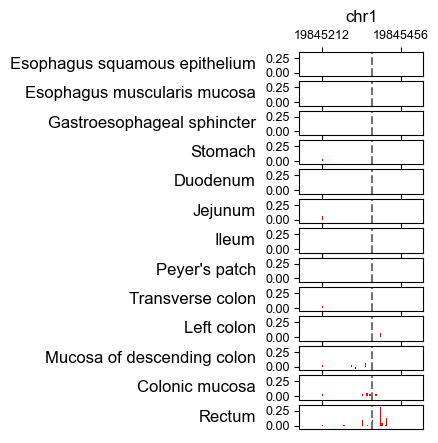

In [15]:
fig, axes = plt.subplots(len(samples_dict), 1, figsize=(1.6,4.9))
# 0-based
chrom, start, end = region.split("_")
start, end = int(start)+50, int(end)-50

ks = ["fwd", "rev"]
strand_colors = ["red", "blue"]
for g in samples_dict:
	row = list(samples_dict).index(g)
	ax = axes[row]
	for k in ks:
		df = df_rpm[(df_rpm["type"]==g) & (df_rpm["orientation"]==k)]
		ax.bar(list(df["position"]), list(df["rpm"]), color=strand_colors[ks.index(k)], align='center', width=3)

	ax.ticklabel_format(useOffset=False, style='plain')
	ax.set_xticks([start, end])
	ax.xaxis.tick_top()
	ax.set_xlabel("")
	if row == 0:
		# Display 1-baesd coordinates
		ax.set_xticklabels([start+1, end+1], fontsize=sfontsize)
		ax.set_title(chrom, fontsize=bfontsize)
	else:
		ax.set_xticklabels([])
			
	ax.set_ylabel(g, rotation=0, ha='right', va="center", fontsize=bfontsize)
	ax.yaxis.set_label_coords(-0.35, 0.5)
	ax.tick_params(axis="y", labelsize=sfontsize)
	ax.set_ylim([-0.06,0.35])
	ax.axvline(x=snp_pos, c="#737373", ls="--")
		
fig.subplots_adjust(hspace=0.2, wspace=0.2)
plt.savefig(f"{PROJECT_DIR_o}figures/Fig3b_top.png", bbox_inches='tight', dpi=300, transparent=True)

# Motifs

In [16]:
inputfile = f"{PROJECT_DIR_r}genomes/human/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta"
with open(inputfile, "r") as f:
	fdict = SeqIO.to_dict(SeqIO.parse(f, "fasta"))

In [17]:
# Generate fasta file for wt and mt sequences (100bp centered on SNP)

outputfile = f"{PROJECT_DIR_o2}temp/UC_example.fa"
snps = [[chrom, snp_pos, rsid, ref, alt]]
utils.generate_fimo_input(snps, fdict, outputfile)

In [18]:
fimo_dir = f"{PROJECT_DIR_s}meme-5.5.7/"
# HOCOMOCO: https://resources.altius.org/~jvierstra/projects/motif-clustering/databases/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme
motif_file = f"{PROJECT_DIR_d2}motifs/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme"
seq_file = f"{PROJECT_DIR_o2}temp/UC_example.fa"
outputfile = f"{PROJECT_DIR_o2}temp/UC_example_FIMO.txt"
utils.run_fimo(fimo_dir, motif_file, seq_file, outputfile)

In [19]:
# The threshold is a p-value of 1e-4
# In the output of FIMO, the start and stop columns use 1-based coordinates and both are inclusive.

df_m = pd.read_table(f"{PROJECT_DIR_o2}temp/UC_example_FIMO.txt")
df_m = df_m[(df_m["start"] < 50) & (50 < df_m["stop"])]
df_m[df_m["sequence_name"].str.contains("wt")]

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,BACH1_HUMAN.H11MO.0.A,NaN,rs6426833_wt,42,54,+,10.05100,9.850000e-05,NaN,NaN
1,BACH1_HUMAN.H11MO.0.A,NaN,rs6426833_wt,42,54,-,12.00000,3.160000e-05,NaN,NaN
4,BACH2_HUMAN.H11MO.0.A,NaN,rs6426833_wt,44,54,-,11.68180,3.830000e-05,NaN,NaN
15,HEN1_HUMAN.H11MO.0.C,NaN,rs6426833_wt,34,53,+,9.04878,3.090000e-05,NaN,NaN
26,MAFB_HUMAN.H11MO.0.B,NaN,rs6426833_wt,42,52,+,10.83330,7.200000e-05,NaN,NaN
31,MAFF_HUMAN.H11MO.0.B,NaN,rs6426833_wt,37,54,-,17.36000,2.930000e-07,NaN,NaN
33,MAFG_HUMAN.H11MO.0.A,NaN,rs6426833_wt,37,54,+,20.01520,1.240000e-07,NaN,NaN
36,MAFK_HUMAN.H11MO.0.A,NaN,rs6426833_wt,37,54,+,17.90910,5.050000e-07,NaN,NaN
39,MAF_HUMAN.H11MO.0.A,NaN,rs6426833_wt,37,55,+,17.08130,1.980000e-07,NaN,NaN
48,NFE2_HUMAN.H11MO.0.A,NaN,rs6426833_wt,42,54,+,10.55560,6.440000e-05,NaN,NaN


In [20]:
df_m[df_m["sequence_name"].str.contains("mt")]

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
2,BACH1_HUMAN.H11MO.0.A,NaN,rs6426833_mt,42,54,+,13.02040,1.640000e-05,NaN,NaN
3,BACH1_HUMAN.H11MO.0.A,NaN,rs6426833_mt,42,54,-,15.05100,3.740000e-06,NaN,NaN
5,BACH2_HUMAN.H11MO.0.A,NaN,rs6426833_mt,42,52,+,14.94550,3.630000e-06,NaN,NaN
6,BACH2_HUMAN.H11MO.0.A,NaN,rs6426833_mt,44,54,-,15.91820,1.320000e-06,NaN,NaN
9,FOSB_HUMAN.H11MO.0.A,NaN,rs6426833_mt,44,52,+,12.72730,3.430000e-05,NaN,NaN
10,FOSL1_HUMAN.H11MO.0.A,NaN,rs6426833_mt,42,53,+,14.40910,1.360000e-05,NaN,NaN
11,FOSL2_HUMAN.H11MO.0.A,NaN,rs6426833_mt,42,53,+,13.15150,2.530000e-05,NaN,NaN
12,FOS_HUMAN.H11MO.0.A,NaN,rs6426833_mt,44,52,+,13.24240,3.020000e-05,NaN,NaN
16,HEN1_HUMAN.H11MO.0.C,NaN,rs6426833_mt,34,53,+,9.03659,3.110000e-05,NaN,NaN
17,JUNB_HUMAN.H11MO.0.A,NaN,rs6426833_mt,43,53,+,15.22730,1.120000e-06,NaN,NaN


In [21]:
motif_pm = utils.parse_meme(motif_file)
motif_pm2 = {}
for motif in motif_pm: 
	motif_pm2[motif] = {"name": motif_pm[motif]["name"],
					   "df": utils.ppm2im(motif_pm[motif]["df"])}
outputfile = f"{PROJECT_DIR_o2}temp/motif_pm.json"
with open(outputfile, 'wb') as f:
    pickle.dump(motif_pm2, f)

In [22]:
index = 17
motif, _, rsid, m_start, m_end = df_m.loc[index][:5]
rsid = rsid.split("_")[0]
fdict[chrom][snp_pos-(50-(m_start-1)):snp_pos-50+m_end]

SeqRecord(seq=Seq('GCTGAGTCGGC'), id='chr1', name='chr1', description='chr1  AC:CM000663.2  gi:568336023  LN:248956422  rl:Chromosome  M5:6aef897c3d6ff0c78aff06ac189178dd  AS:GRCh38', dbxrefs=[])

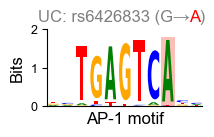

In [23]:
df = motif_pm2[motif]["df"]
fig, ax = plt.subplots(1,1,figsize=(2,1))
logo = logomaker.Logo(df, vpad=.1, width=.8, ax=ax)
logo.highlight_position(p=50-(int(m_start)-1)+1, color="#fb8072", alpha=.5)
ax.set_ylabel("Bits", fontsize=bfontsize)
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(["0", "1", "2"], fontsize=sfontsize)
ax.set_xlabel("AP-1 motif", fontsize=bfontsize)
ax.set_xticks([])
ax.tick_params(labelsize=sfontsize) 
ax.spines[["top","right"]].set_visible(False)
ax.set_title("")
x = 0.95
y = 1.1
ax.text(x, y, f"UC: {rsid} ({ref}\u2192 ", transform=ax.transAxes, fontsize=bfontsize, color="gray", ha="right")
ax.text(x, y, alt, transform=ax.transAxes, fontsize=bfontsize, color="red", ha="center")
ax.text(x, y, " )", transform=ax.transAxes, fontsize=bfontsize, color="gray", ha="left")
plt.savefig(f"{PROJECT_DIR_o}figures/Fig3b_bottom.pdf", bbox_inches='tight')

# Luciferase experiments

In [25]:
# Get the data from Mauricio

dfs = {}
inputfile = f"{PROJECT_DIR_d2}luc_assay/uc_mt_luc_analysis.xlsx"
dfs["Caco-2"] = pd.read_excel(inputfile, index_col=0, nrows=40)
dfs["Caco-2"].head(2)

,caco2_firefly_replicate_1,caco2_firefly_replicate_2,caco2_firefly_replicate_3,geometric_mean,standard_deviation,standard_error,mean_plus_deviation,mean_minus_deviation,mean_log_2,plus_deviation_log_2,...,caco2_renilla_replicate_1,caco2_renilla_replicate_2,caco2_renilla_replicate_3,geometric_mean.1,standard_deviation.1,Unnamed: 18,x,y,Unnamed: 21,p-value
no_transfection,19.0,40.0,18.0,23.916376,10.143416,2.813277,34.059792,13.772960,4.579927,5.089998,...,19.0,18.0,12.0,16.010410,3.091206,NaN,rs17229679_WT,2.859131,0.725065,NaN
cmv584,2198.0,724.0,994.0,1165.156367,640.762740,177.715609,1805.919107,524.393628,10.186308,10.818518,...,705.0,773.0,471.0,635.520903,129.350514,NaN,rs17229679_MT,4.938468,0.790517,0.052896


In [26]:
dfs["HCT116"] = pd.read_excel(inputfile, index_col=0, header=43)
dfs["HCT116"].head(2)

,hct116_firefly+replicate_1,hct116_firefly+replicate_2,hct116_firefly+replicate_3,geometric_mean,standard_deviation,standard_error,mean_plus_deviation,mean_minus_deviation,mean_log_2,plus_deviation_log_2,...,hct116_renilla_replicate_1,hct116_renilla_replicate_2,hct116_renilla_replicate_3,geometric_mean.1,standard_deviation.1,Unnamed: 18,x,y,Unnamed: 21,Unnamed: 22
no_transfection,52.0,44.0,41.0,45.437381,4.642796,1.287680,50.080177,40.794585,5.505808,5.646168,...,30.0,26.0,34.0,29.821158,3.265986,NaN,rs17229679_WT,1.032580,0.163584,NaN
cmv584,55910.0,62102.0,44455.0,53642.033279,7310.376932,2027.533759,60952.410211,46331.656347,15.711076,15.895396,...,26801.0,35592.0,21034.0,27173.260591,5985.866075,NaN,rs17229679_MT,1.231582,0.257932,0.379112


In [27]:
ks = ["Caco-2", "HCT116"]
values = defaultdict(dict)
for k in ks:
	columns = dfs[k].columns[:3]
	for index, row in dfs[k].iterrows():
		values[k][index] = [row[col] for col in columns]

In [32]:
tests = [# neg control
		"egfp",
		# pos control
		"cmv584", "rsv",
		 ] + ["rs6426833"]
results = []
for k, test in itertools.product(ks, tests):
	if test == "rs6426833":
		for t in ["wt", "mt"]:
			k2 = f"{test[2:4]}_{t}_background_subtraction_firefly/renilla"
			for v in values[k][k2]:
				results.append([k, f"{test}_{t}", v, t])

	else:
		k2 = f"{test}_background_subtraction_firefly/renilla"
		for v in values[k][k2]:
			results.append([k, test.upper(), v, np.nan])			
df_test = pd.DataFrame(results, columns=["Cell line", "Test", "Value", "Type"])
df_test.head(2)

,Cell line,Test,Value,Type
0,Caco-2,EGFP,9.179383e-03,NaN
1,Caco-2,EGFP,2.375356e-09,NaN


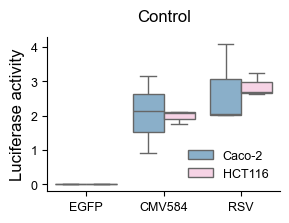

In [38]:
# Check consistency between cell lines

fig, ax = plt.subplots(figsize=(3,2))
g = sns.boxplot(data=df_test[df_test["Test"].isin([t.upper() for t in tests[:3]])], x="Test", y="Value", 
				hue="Cell line", palette=["#80b1d3", "#fccde5"], ax=ax)
g.set_title("Control", fontsize=bfontsize, y=1.05)
g.set_ylabel("Luciferase activity", fontsize=bfontsize)
g.set_xlabel("")
g.spines[["top","right"]].set_visible(False)
g.legend(fontsize=sfontsize, frameon=False)
g.tick_params(labelsize=sfontsize)

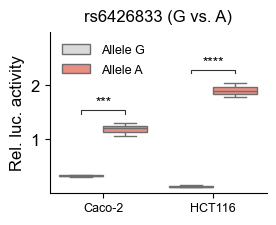

In [52]:
fig, ax = plt.subplots(figsize=(2.8,2.1))
hue_plot_params = {
					"data": df_test[df_test["Test"].str.contains("rs6426833")],
					"x": "Cell line",
					"y": "Value",
					"palette": ["#d9d9d9","#fb8072"],
					"hue": "Type",
					"hue_order": ["wt","mt"]
					}
g = sns.boxplot(ax=ax, **hue_plot_params)
g.spines[["top","right"]].set_visible(False)
g.set_title("rs6426833 (G vs. A)", fontsize=bfontsize, y=1.01)

legend = g.legend()
new_labels = [f"Allele {ref}", f"Allele {alt}"]
for text, label in zip(legend.get_texts(), new_labels):
	text.set_text(label)
	text.set_fontsize(sfontsize)
legend.set_frame_on(False)

g.set_xlabel("")
g.tick_params(axis="x", labelsize=sfontsize)
g.set_ylabel("Rel. luc. activity", fontsize=bfontsize)
g.set_yticks([1,2])
g.set_ylim([0,3])
g.tick_params(axis="y", labelsize=bfontsize)

pairs = [[(k, "wt"), (k, "mt")] for k in ks]
annotator = Annotator(g, pairs, **hue_plot_params)
# This is a test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.
annotator.configure(test="t-test_ind", comparisons_correction="BH", line_width=lw,
					text_offset=1, text_format="star", verbose=False)
_, results = annotator.apply_and_annotate()

plt.savefig(f"{PROJECT_DIR_o}figures/Fig3c.pdf", bbox_inches='tight', transparent=True)